# Practical: modeling ice temperature over 125 000 years at Summit Greenland

<img src="Figures/summitcampGRIP.jpg" width=350 height=300 />
<center><i>The ice core drilling camp at Summit station, Greenland (1989-1995)</i></center>

# Part 0: Information
This is the notebook associated with the practical on ice sheet and glacier thermodynamics. It is part of the spring 2023 Glacier and Ice Sheet Dynamics course (EAS 4403/8803). The practical is given by Vincent Verjans (vverjans3@gatech.edu).

To run the model for this practical, you will need to have anaconda installed with the following libraries:
numpy, matplotlib, netCDF4, scipy, notebook

To do this, first download and install anaconda following the guidelines from: https://docs.anaconda.com/anaconda/install/

Second, you will need to create an anaconda environment and download a few python libraries. To do this, you will use the anaconda terminal.

- On Windows: click Start, search for Anaconda Prompt, and click to open.
- On Mac: use Cmd+Space to open Spotlight Search and type “Navigator” to open the program.
- On Linux: open the terminal.

Create the environment for this course by typing:

conda create --name icesheetdynamics numpy matplotlib netcdf4 scipy notebook

Finally, do:

conda activate icesheetdynamics

Everything should be ready!


# Introduction
In this practical, we will use a 125 000 year long record of atmospheric surfce temperatures at Summit Greenland. The surface temperature time series is derived from isotope-analysis of the GRIP ice core (Johnsen et al., 1992). Furthermore, the ice temperature was also directly measured from the core. As such, the ice core temperature represent present-day ice temperatures, but which have been influenced by the changing climatic conditions over the past. __Can we reproduce the observed ice core temperature profile by using the reconstructed atmospheric surface temperatures as forcing to a numerical model?__
<img src="Figures/gripPlots.png" width=750 height=500 />

This notebook has a workflow with two different parts. First, we download the ice core data and the surface temperature time series. The second part is a one-dimensional advection-diffusion model to simulate ice temperature over time. The model is fully coded already, but you will need to understand how it works, to investigate the sensitivity of the results to parameters, and to implement some more advanced capabilities.

Let's start by importing the python libraries needed for this practical.

In [1]:
import os
import sys
import urllib
import math
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.sparse import diags

# Advection-diffusion: theory
We use the 1D transient advection-diffusion heat equation (Eq.1):
$$
\frac{\partial T}{\partial t} = \kappa\frac{\partial^2 T}{\partial z^2}-w\frac{\partial T}{\partial z} \;\;\;\;\;\;\;\; \text{(1)}
$$
where $T$ is the ice temperature, $\kappa$ is the ice thermal diffusivity, and $w$ is the vertical ice velocity. For completeness, all the variables and parameters of the model are given in the Table below.

| Variable/Parameter | Value | Symbol in the equations | Symbol in the code | Units |
| :---: | :---: | :---: | :---: | :---: |
| Surface temperature | Variable | $T_S$ | surfT | $K$ |
| Ice thickness | Variable | $H$ | bigH | $m$ |
| Accumulation rate | Variable | $\dot{b}$ | bdot | $m$ $s^{-1}$ |
| Geothermal heat flux | Variable | $G$ | bigG | $W$ $m^{-2}$ |
| Thermal conductivity | $2.10$ | $k$ | kcond | $W$ $m^{-1}$ $K^{-1}$ |
| Density | $917$ | $\rho_i$ | rhoi | $\textit{kg}$ $m^{-3}$ |
| Specific heat capacity | $2091$ | $c_{p}$ | cp | $J$ $\textit{kg}^{-1}$ $K^{-1}$ |
| Thermal diffusivity | $\frac{k}{\rho_{i}c_{p}}$ | $\kappa$ | kappa | $m^{2}$ $s^{-1}$ |
| Ice viscosity coefficient | Variable | $A(T)$ | bigA | $Pa^{3}$ $s^{-1}$ |
| Ice vertical velocity | Variable | $w$ | wvel | $m$ $s^{-1}$ |
| Ice horizontal velocity | Variable | $u$ | uvel | $m$ $s^{-1}$ |
| Ice strain rate | $\frac{\partial u}{\partial z}$ | $\dot{\epsilon}$ | strainrate | $s^{-1}$ |
| Deviatoric stress | Variable | $\tau$ | devstress | $Pa$ |
| Glen exponent | 3 | $n$ | nglen | \ |

The advection-diffusion equation specifies that any change in temperature at a given vertical level is caused by heat diffusion following the temperature gradient ($\frac{\partial^2 T}{\partial z^2}$ term) and/or by heat advection following the ice velocity direction ($\frac{\partial T}{\partial z}$ term). 

__What processes are neglected in this form of the heat equation? And why is it okay (or not okay) to neglect them?__

First, you should download the data. The downloaded surface temperature time series (surfTgrip) and ice core temperature profile (coreTgrip) are shown in the figure above (in the Introduction section).

In [2]:
def getGRIPtemperatureTimeSeries():
    
    locpath = 'datasetsGRIP/surftemperaturedata.nc'
    if(os.path.exists(locpath)==False):
        if(os.path.isdir('datasetsGRIP/')==False):
            os.mkdir('datasetsGRIP/')
        linkGreenland = 'http://websrv.cs.umt.edu/isis/images/a/a5/Greenland_5km_v1.1.nc'
        urllib.request.urlretrieve(linkGreenland,locpath)
        print('SeaRise Greenland temperature data downloaded')
    else:
        print('Using existing SeaRise Greenland temperature data')
    ds            = nc.Dataset(locpath)
    deltaTemp     = np.array(ds.variables['temp_time_series'])
    ntot          = len(deltaTemp)
    tm0           = np.array(ds.variables['sealeveltimes'])
    tmcore        = np.linspace(-1*max(tm0),0,ntot)
    deltaTemp     = np.flip(deltaTemp)
    ds.close()
    presentdayT  = 243.15 # [K] (see Summit Station page Wikipedia)
    forcingTemp  = presentdayT+deltaTemp
    return(tmcore,forcingTemp)

def getGRIPicecoretemperatures():
    
    locpath = 'datasetsGRIP/icecoredata.txt'
    if(os.path.exists(locpath)==False):
        if(os.path.isdir('datasetsGRIP/')==False):
            os.mkdir('datasetsGRIP/')
        linkGRIPcore = 'https://www.ncei.noaa.gov/pub/data/paleo/icecore/greenland/summit/grip/physical/griptemp.txt'
        urllib.request.urlretrieve(linkGRIPcore,locpath)
        print('GRIP ice core data downloaded')
    else:
        print('Using existing GRIP ice core data')
    fread        = open(locpath,'r')
    data         = fread.read().split()
    fread.close()
    ind          = data.index('Midpoint')    
    datavalues   = np.array(data[ind+1:]).astype(float)
    depthscore   = datavalues[0::2]
    zlvlcore     = -1*(depthscore-max(depthscore))
    iceTemp      = datavalues[1::2]+273.15
    return(zlvlcore,iceTemp)

tmgrip,surfTgrip   = getGRIPtemperatureTimeSeries()
zlvlgrip,coreTgrip = getGRIPicecoretemperatures()


Using existing SeaRise Greenland temperature data
Using existing GRIP ice core data


Now, we want to set up our model configuration. This involves defining the variables and parameters needed for our simulations. Here are the specificities of this run:
- We set a one-dimensional vertical grid (zgrid)

In [3]:
### Vertical grid ###
deltaz   = 30.0
zgrid    = np.arange(0,3030+1,deltaz)
nnz      = len(zgrid)
bigH     = max(abs(zgrid)) #ice column thickness

- We use estimates of of present-day accumulation (bdotP, P for present-day). And do not forget the conversion to S.I. units!

In [4]:
### Present-day accumulation rate ###
bdotP    = 0.27 #units: m water eq. per year
spyr     = 365.25*24*3600 #number of seconds in one year
bdotsecP = bdotP/spyr #units: m water eq. per second

- We define the ice thermodynamical and mechanical parameters.

In [5]:
### Ice parameters ###
kcond   = 2.10*np.ones(nnz) #thermal conductivity [W m-1 K-1]
cp      = 2091*np.ones(nnz) #specific heat [J kg-1 K-1]
rhoi    = 917 #ice density [kg m-3]
kappa   = kcond/(rhoi*cp) #thermal diffusivity [m2 s-1]
nglen   = 3 #Glen exponent

- We use estimates of geothermal heat flux at Summit Greenland (bigG) from Colgan et al. (2022). The geothermal heat flux and the ice thermal conductivity fully specify the temperature gradient at the ice base (Neumann boundary condition). Note here that we neglect frictional heating.

In [6]:
### Geothermal heat flux ###
bigG     = 40*1e-3 # [W m-2] (see Fig. 7 of Colgan et al.(2022))
dtdz_b   = -1*bigG/kcond[0] #Neumann BC

- Accumulation rates show a strong relation to temperature over paleo timescales. We use the parameterization of Huybrechts (1996). In this parameterization, the change in accumulation with respect to present-day accumulation is assumed to be a direct function of the change in surface temperature with respect to present-day temperature:
$$
\dot{b}(t) = \dot{b}_0 (1-s)^{\Delta T}
$$

$$
\Delta T = T_{S}(t)-T_{S,0}
$$

$$
\begin{align}
s=
\begin{cases}
0.05, & \text{if $\Delta T \geq 273.15K$} \\
0.05-0.005\Delta T, & \text{if $263.15K \leq \Delta T < 273.15K$} \\
0.10, & \text{if $\Delta T \leq 263.15K$} \\
\end{cases}
\end{align}
$$

$\;\;\;\;$ __How do you interpret this parameterization? What is the physical mechanism behind it?__

$\;\;\;\;$ We retrieve the present-day and 125 kyr BP temperatures. Using the parameterization, we compute the accumulation rate estimate of 125 kyr BP.

In [7]:
def parambdotHuybrechts1996(bdotpres,deltaTpres):
    '''
    Parameterization of change in accumulation rates over paleo-timescales
    as a function of change in temperature
    Eq. (6) of Huybrechts (1996)
    '''
    if(deltaTpres>=0):
        smalls = 0.05
    elif(deltaTpres<0 and deltaTpres>=-10):
        smalls = 0.05-0.005*deltaTpres
    else:
        smalls = 0.1
    bdotpast = bdotpres*(1+smalls)**deltaTpres
    return(bdotpast)

### Values 125 kyr ago ###
surfT125ky   = surfTgrip[0]
surfTP       = surfTgrip[-1]
deltaT125ky  = surfT125ky-surfTP
bdotsec125ky = parambdotHuybrechts1996(bdotsecP,deltaT125ky)


- We initialize the ice temperature profile with the Robin model (which we saw in class). As climatic forcing for the Robin solution, we use the temperature at the start of surface temperature time series (125 kyr BP).

In [8]:
def robinTprofile(zz,surfT,bdot,bigG):
    '''
    Analytic temperature profile, Robin solution
    All input arguments should have SI units
    '''
    bigH    = max(abs(zz)) #ice column thickness
    kcond   = 2.10 #thermal conductivity [W m-1 K-1]
    cp      = 2091 #specific heat [J kg-1 K-1]
    rhoi    = 917 #ice density [kg m-3]
    kappa   = kcond/(rhoi*cp) #thermal diffusivity [m2 s-1]
    smallq  = np.sqrt(2*kappa*bigH/bdot)
    dtdz_b  = -1*bigG/kcond #Neumann BC
    # Compute temperature profile #
    t1erf = np.array([math.erf(abs(zval)/smallq) for zval in zz]) 
    t2erf = math.erf(bigH/smallq)
    outT  = surfT+np.sqrt(np.pi)/2*dtdz_b*(t1erf-t2erf)*smallq
    return(outT)

### Compute initial temperature profile with the Robin model ###
initT = robinTprofile(zgrid,surfT125ky,bdotsec125ky,bigG)


- We set up the time stepping scheme. Note that we will step through time from the beginning of the reconstructed surface temperature time series (125 kyr BP) to the end (present-day).

In [9]:
### Timing parameters ###
deltatYr     = 100.0
dataTimeYr   = np.arange(min(tmgrip),tmgrip[-1]+1,deltatYr)
deltatSec    = deltatYr*spyr
dataTimeSec  = dataTimeYr*spyr
nsteps       = len(dataTimeSec)

- We have no heat source term in our model, so we just set this to 0.

In [10]:
### Source term ###
sourceterm = np.zeros(nnz)

- And finally, we set up plotting options.

In [11]:
### Plotting parameters ###
lsPlotTimeSteps = [-100000,-50000,0]
lsTimeLabels    = (1e-3*np.copy(lsPlotTimeSteps)).astype(int)
nplots          = len(lsPlotTimeSteps)
lsSavedProfiles = []
lsColors        = plt.cm.rainbow(np.linspace(0,1,nplots))

Throughout the model run, be careful about the units. The model assumes that every variable is in S.I. units.

Once the model configuration is set up, we start the looping over the time steps. At each time step, we:
- Interpolate the surface temperature time series to use the adequate surface temperature forcing (ttsurfT).
- Compute the accumulation modification according to the parameterization (ttbdotsec).
- Compute the vertical velocity (wvel). __Do you understand the formula used to calculate wvel?__ Note also that wvel is subsequently modified in wvelstag. __Why do we need wvelstag instead of wvel?__
- Calculate the coefficients that will be used in our system of equations (alpha,beta,gamma), which will be solved as matrix system:
$$
\begin{bmatrix}
   \beta_1 & -\gamma_1 & 0 & 0 & 0 & ... & ... & ... & ...& 0 & 0 & 0 \\
   -\alpha_2 & \beta_2 & -\gamma_2 & 0 & 0 & ... & ... & ... & ...& 0 & 0 & 0 \\
   0 & -\alpha_3 & \beta_3 & -\gamma_3 & 0 & ... & ... & ... & ...& 0 & 0 & 0 \\
   . & . & . & . & ... & ... & ... & ... & ...& . & . & . \\
   0 & 0 & 0 & 0 & 0 & ... & ... & ... & ...& -\alpha_{n-1} & \beta_{n-1} & -\gamma_{n-1} \\
   0 & 0 & 0 & 0 & 0 & ... & ... & ... & ...& 0 & -\alpha_{n} & \beta_{n} \\
\end{bmatrix}
\begin{bmatrix}
    T_{1} \\ T_{2} \\ T_{3} \\ . \\ T_{n-1} \\ T_{n}
\end{bmatrix}
= \begin{bmatrix}
    \theta_1 \\ \theta_2 \\ \theta_3 \\ . \\ \theta_{n-1} \\ \theta_{n} 
\end{bmatrix}
$$
- Set our boundary conditions (this is a very delicate and important step). Think about the boundary conditions imposed. __How do they translate in terms of equations?__ Think also: __is the surface at the start of the end of our array?__
- Solve our system of equations. Note that we use the built-in numpy capabilities to invert and to multiply matrices.
- We retrieve the newly calculated temperature profile (newT).
- Note that we save the temperature profile if the time step is one of our chosen time steps for plotting (lsPlotTimeSteps).

Finally, we simply plot the temperature profiles saved during the time stepping process, along with the GRIP ice core temperature observations and the initial temperature profile from the Robin solution.

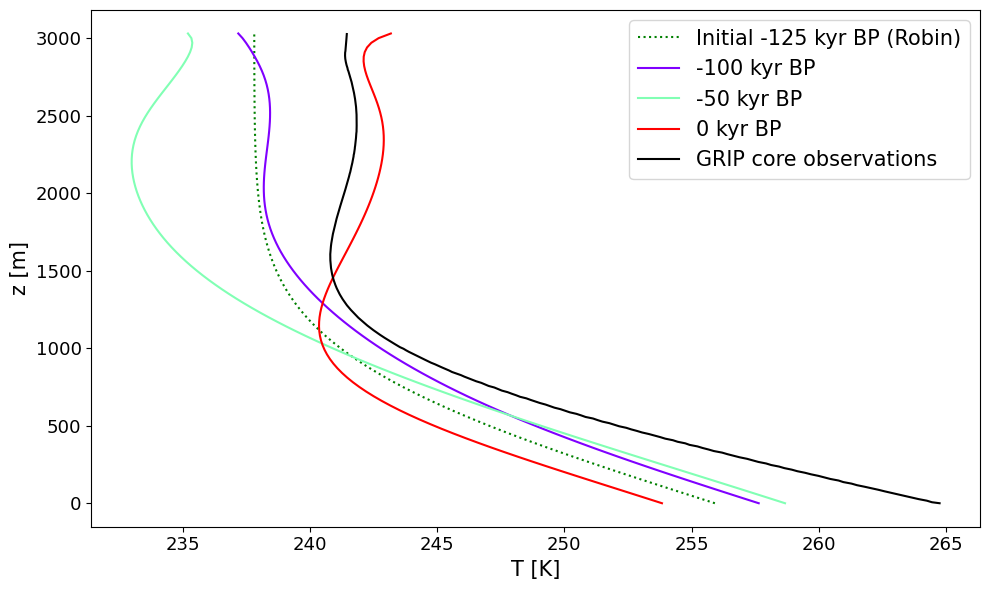

In [12]:
### Start the time stepping loop ###
newT  = np.copy(initT)
for tt in range(nsteps):
    
    ### Interpolate surface temperature forcing at current time step tt ###
    ttsurfT   = np.interp(dataTimeYr[tt],tmgrip,surfTgrip)
    ### Compute accumulation parameterization ###
    ttbdotsec = parambdotHuybrechts1996(bdotsecP,ttsurfT-surfTP)
    
    ### Vertical velocity ###
    wvel      = -1*ttbdotsec*(zgrid/bigH)
    wvelstag0 = (wvel[0:-1]+wvel[1:])/2
    wvelstag  = np.append(0,wvelstag0)
    
    ### Tri-diagonal solver parameters ###
    alpha  = kappa*deltatSec/(deltaz**2)*np.ones(nnz) #[unitless]
    beta   = 1+2*kappa*deltatSec/(deltaz**2)-wvelstag*deltatSec/deltaz #[unitless]
    gamma  = kappa*deltatSec/(deltaz**2)-wvelstag*deltatSec/deltaz #[unitless]
    bigmat = diags(diagonals=[-1*alpha[1:],beta,-1*gamma[0:-1]],offsets=[-1,0,1]).toarray() #tri-diagonal matrix
    
    ### Right-hand side of the matrix system ###
    oldT      = np.copy(newT)
    theta     = np.copy(oldT)+sourceterm
    theta[-1] = 1*ttsurfT
    theta[0]  = dtdz_b*deltaz
    
    ### Boundary conditions
    bigmat[0,0]   = -1.0
    bigmat[0,1]   = 1.0
    bigmat[-1,-2] = 0.0
    bigmat[-1,-1] = 1.0
    
    ### Solve ###
    newT          = (np.linalg.inv(bigmat))@theta    
    
    ### Save for plotting ###
    if(len(lsPlotTimeSteps)>0 and abs(dataTimeYr[tt]-lsPlotTimeSteps[0])<=deltatYr):
        lsPlotTimeSteps = lsPlotTimeSteps[1:]
        lsSavedProfiles.append(newT)
    

### Plotting ###
fig = plt.figure(figsize=[10,6])
ax  = plt.subplot(111)
ax.plot(initT,zgrid,'g',linestyle=':',label='Initial -125 kyr BP (Robin)')
for pp in range(nplots):
    ax.plot(lsSavedProfiles[pp],zgrid,c=lsColors[pp],label=f'{lsTimeLabels[pp]} kyr BP')
ax.plot(coreTgrip,zlvlgrip,'k',label='GRIP core observations')
ax.tick_params(axis='both',which='major',labelsize=13)
ax.set_xlabel('T [K]',fontsize=15),ax.set_ylabel('z [m]',fontsize=15)
ax.legend(loc='best',fontsize=15)
fig.tight_layout()


## Questions
- How well does the model agree with the GRIP ice core temperature observations?
- Which of our simplifications could explain the discrepancies? Justify based on your knowledge of ice thermodynamics.
- How do you interpret the small bulge at $z=\sim 2900 m$ and the larger bulge at $z=\sim 2400 m$? Does the model reproduce these features?


# Coupling

In reality, ice specific heat ($c_p$) anf thermal conductivity ($k$) depend on ice temperature itself. Proposed parameterizations for these dependencies are given by Cuffey and Paterson (2010):
$$
c_p = 152.5 + 7.122 \; T
$$

$$
k = 9.828 \; \text{exp}\left(-5.7\times 10^{-3} \; T\right)
$$

In principle, accounting for these dependencies can affect the temperature profile. Using the functions below (cpCuffeyPaterson and thermalconductivityCuffeyPaterson), __try to modify the model code to account for the coupling of $c_p$ and $k$ with ice temperature__.


In [ ]:
def cpCuffeyPaterson(iceT):
    '''
    Ice specific heat as a function if ice temperature in K
    Eq. (9.1) of Cuffey and Paterson (2010)
    '''
    out_cp = 152.5+7.122*iceT #[J kg-1 K-1]
    return(out_cp)

def thermalconductivityCuffeyPaterson(iceT):
    '''
    Ice thermal conductivity as a function if ice temperature in K
    Eq. (9.2) of Cuffey and Paterson (2010)
    '''
    out_k = 9.828*np.exp(-5.7*1e-3*iceT)
    return(out_k)

# Strain heating

The discrepancies between our results and the observations are most pronounced close to the ice column base. One possible reason is that the geothermal heat flux could be underestimated, as this remains a variable difficult to constrain. However, ice deformation due to vertical velocity gradients causes strain heating. And our model does not account for this.
Surface velocities at Summit station are $\sim 1 m \textit{yr}^{-1}$ (see for example Fig.2 of Hawley et al., 2020). A simplifying (but reasonable) assumption is to use a parabolic horizontal velocity profile. From there, one can compute the ice strain rate:
$$
\dot{\epsilon} = \frac{\partial u}{\partial z}
$$
where $u$ is the horizontal velocity. The strain rates are related to deviatoric stress ($\tau$) via Glen's flow law:
$$
\dot{\epsilon} = A(T) \; \tau^n
$$
with $n$ the Glen exponent, typically close to 3, and $A(T)$ the ice flow parameter. As its notation indicates, $A(T)$ depends on ice temperature, and we will use the formulation of Payne et al. (2000):
$$
A(T) = a \; \text{exp}\left(\frac{-Q}{R\;T}\right)
$$

$$
\begin{align}
a=
\begin{cases}
3.61\times10^{-13} Pa^{-3}s^{-1}, & \text{if $T \leq 263.15K$} \\
1.73\times10^{3} Pa^{-3}s^{-1}, & \text{if $T > 263.15K$} \\
\end{cases}
\end{align}
$$

$$
\begin{align}
Q=
\begin{cases}
6.0\times10^{4} J \;mol^{-1}, & \text{if $T \leq 263.15K$} \\
13.9\times10^{4} J \;mol^{-1}, & \text{if $T > 263.15K$} \\
\end{cases}
\end{align}
$$

With all this in mind, we can calculate the strain heating term:
$$
2\frac{\dot{\epsilon}\; \tau}{\rho_{i} \; c_{p}}
$$

Based on the code snippet below, __try to modify the model code to account for the strain heating term__.

In [ ]:
def viscosityPayne2000(iceTarray):
    '''
    Ice viscosity as a function of temperature
    Eq. (3) of Payne et al. (2000)
    '''
    ntot    = len(iceTarray)
    if(np.any(iceTarray<0)):
        iceTarray = iceTarray+273.15
    uniR    = 8.314 #[J mol-1 K-1]
    ### Prefactor ###
    smalla                      = np.ones(ntot)
    smalla[iceTarray<263.15]    = 3.61*1e-13 #[Pa-3 s-1]
    smalla[iceTarray>=263.15]   = 1.73*1e3 #[Pa-3 s-1]
    ### Activation energy ###
    bigq                        = np.ones(ntot)
    bigq[iceTarray<263.15]      = 6*1e4 #[J mol-1]
    bigq[iceTarray>=263.15]     = 13.9*1e4 #[J mol-1]
    ### Compute flow factor ###
    flowfac = smalla*np.exp(-1*bigq/(uniR*iceTarray)) #[Pa3 s-1]
    return(flowfac)

##### Strain rates #####
usurf = 1.0/spyr #horizontal velocity at the surface [m s-1]
uprof = usurf*(zgrid/max(zgrid))**(1/2) #vertical profile of horizontal velocity [m s-1]
strainrate = np.append((uprof[1:]-uprof[0:-1])/deltaz,0) #vertical profile of strain rates [s-1]

### Source term from strain heating ###
bigA       = viscosityPayne2000(newT) #ice viscosity coefficient [Pa3 s-1]
devstress  = (strainrate/bigA)**(1/nglen) #deviatoric stress [Pa]
strheating = 2*strainrate*devstress/(rhoi*cp) # [K s-1]
sourceterm = deltatSec*strheating #[K]



# Conclusions

If you have made it until here, congratulations! You now have a better understanding of how to model ice temperature, and how complicated it can get. Do not forget that we are here focusing on a location close to an ice divide, and we thus reduce the complexity to a 1D case. The reality can be more messy.

Below, you will find the final code accounting for both the coupling of ice parameters with ice temperature and for strain heating. Notice that accounting for the dependence of $c_p$ and $k$ on the ice temperature and for the strain heating improves the model results with respect to the observations. Feel free to play around with the code. And if you have any questions, please do not hesitate to contact me: vverjans3@gatech.edu

# Full code

Using existing SeaRise Greenland temperature data
Using existing GRIP ice core data


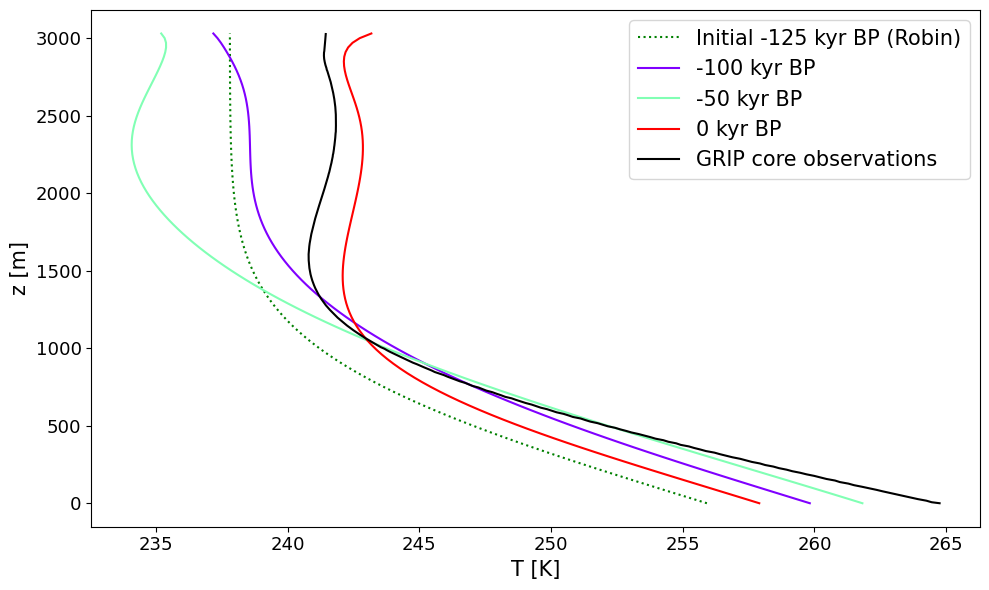

In [13]:
import os
import sys
import urllib
import math
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.sparse import diags


def getGRIPtemperatureTimeSeries():
    
    locpath = 'datasetsGRIP/surftemperaturedata.nc'
    if(os.path.exists(locpath)==False):
        if(os.path.isdir('datasetsGRIP/')==False):
            os.mkdir('datasetsGRIP/')
        linkGreenland = 'http://websrv.cs.umt.edu/isis/images/a/a5/Greenland_5km_v1.1.nc'
        urllib.request.urlretrieve(linkGreenland,locpath)
        print('SeaRise Greenland temperature data downloaded')
    else:
        print('Using existing SeaRise Greenland temperature data')
    ds            = nc.Dataset(locpath)
    deltaTemp     = np.array(ds.variables['temp_time_series'])
    ntot          = len(deltaTemp)
    tm0           = np.array(ds.variables['sealeveltimes'])
    tmcore        = np.linspace(-1*max(tm0),0,ntot)
    deltaTemp     = np.flip(deltaTemp)
    ds.close()
    presentdayT  = 243.15 # [K] (see Summit Station page Wikipedia)
    forcingTemp  = presentdayT+deltaTemp
    return(tmcore,forcingTemp)

def getGRIPicecoretemperatures():
    
    locpath = 'datasetsGRIP/icecoredata.txt'
    if(os.path.exists(locpath)==False):
        if(os.path.isdir('datasetsGRIP/')==False):
            os.mkdir('datasetsGRIP/')
        linkGRIPcore = 'https://www.ncei.noaa.gov/pub/data/paleo/icecore/greenland/summit/grip/physical/griptemp.txt'
        urllib.request.urlretrieve(linkGRIPcore,locpath)
        print('GRIP ice core data downloaded')
    else:
        print('Using existing GRIP ice core data')
    fread        = open(locpath,'r')
    data         = fread.read().split()
    fread.close()
    ind          = data.index('Midpoint')    
    datavalues   = np.array(data[ind+1:]).astype(float)
    depthscore   = datavalues[0::2]
    zlvlcore     = -1*(depthscore-max(depthscore))
    iceTemp      = datavalues[1::2]+273.15
    return(zlvlcore,iceTemp)

def robinTprofile(zz,surfT,bdot,bigG):
    '''
    Analytic temperature profile, Robin solution
    All input arguments should have SI units
    '''
    bigH    = max(abs(zz)) #ice column thickness
    kcond   = 2.10 #thermal conductivity [W m-1 K-1]
    cp      = 2091 #specific heat [J kg-1 K-1]
    rhoi    = 917 #ice density [kg m-3]
    kappa   = kcond/(rhoi*cp) #thermal diffusivity [m2 s-1]
    smallq  = np.sqrt(2*kappa*bigH/bdot)
    dtdz_b  = -1*bigG/kcond #Neumann BC
    # Compute temperature profile #
    t1erf = np.array([math.erf(abs(zval)/smallq) for zval in zz]) 
    t2erf = math.erf(bigH/smallq)
    outT  = surfT+np.sqrt(np.pi)/2*dtdz_b*(t1erf-t2erf)*smallq
    return(outT)

def parambdotHuybrechts1996(bdotpres,deltaTpres):
    
    if(deltaTpres>=0):
        smalls = 0.05
    elif(deltaTpres<0 and deltaTpres>=-10):
        smalls = 0.05-0.005*deltaTpres
    else:
        smalls = 0.1
    bdotpast = bdotpres*(1+smalls)**deltaTpres
    return(bdotpast)

def cpCuffeyPaterson(iceT):
    '''
    Ice specific heat as a function if ice temperature in K
    Eq. (9.1) of Cuffey and Paterson (2010)
    '''
    out_cp = 152.5+7.122*iceT #[J kg-1 K-1]
    return(out_cp)

def thermalconductivityCuffeyPaterson(iceT):
    '''
    Ice thermal conductivity as a function if ice temperature in K
    Eq. (9.2) of Cuffey and Paterson (2010)
    '''
    out_k = 9.828*np.exp(-5.7*1e-3*iceT)
    return(out_k)

def viscosityPayne2000(iceTarray):
    '''
    Ice viscosity as a function of temperature
    Eq. (3) of Payne et al. (2000)
    '''
    ntot    = len(iceTarray)
    if(np.any(iceTarray<0)):
        iceTarray = iceTarray+273.15
    uniR    = 8.314 #[J mol-1 K-1]
    ### Prefactor ###
    smalla                      = np.ones(ntot)
    smalla[iceTarray<263.15]    = 3.61*1e-13 #[Pa-3 s-1]
    smalla[iceTarray>=263.15]   = 1.73*1e3 #[Pa-3 s-1]
    ### Activation energy ###
    bigq                        = np.ones(ntot)
    bigq[iceTarray<263.15]      = 6*1e4 #[J mol-1]
    bigq[iceTarray>=263.15]     = 13.9*1e4 #[J mol-1]
    ### Compute flow factor ###
    flowfac = smalla*np.exp(-1*bigq/(uniR*iceTarray)) #[Pa3 s-1]
    return(flowfac)

tmgrip,surfTgrip = getGRIPtemperatureTimeSeries()
zlvlgrip,coreTgrip = getGRIPicecoretemperatures()
    
### Vertical grid ###
deltaz   = 30.0
zgrid    = np.arange(0,3030+1,deltaz)
nnz      = len(zgrid)
bigH     = max(abs(zgrid)) #ice column thickness

### Present-day accumulation rate ###
bdotP    = 0.27
spyr     = 365.25*24*3600 #number of seconds in one year
bdotsecP = bdotP/spyr

### Ice parameters ###
kcond   = 2.10*np.ones(nnz) #thermal conductivity [W m-1 K-1]
cp      = 2091*np.ones(nnz) #specific heat [J kg-1 K-1]
rhoi    = 917 #ice density [kg m-3]
kappa   = kcond/(rhoi*cp) #thermal diffusivity [m2 s-1]
nglen   = 3 #Glen exponent


### Geothermal heat flux ###
bigG     = 40*1e-3 # [W m-2] (see Fig. 7 of Colgan et al.(2022))
dtdz_b   = -1*bigG/kcond[0] #Neumann BC

### Values 125 kyr ago ###
surfT125ky   = surfTgrip[0]
surfTP       = surfTgrip[-1]
deltaT125ky  = surfT125ky-surfTP
bdotsec125ky = parambdotHuybrechts1996(bdotsecP,deltaT125ky)
initT        = robinTprofile(zgrid,surfT125ky,bdotsec125ky,bigG)

##### Strain rates #####
usurf = 1.0/spyr #horizontal velocity at the surface [m s-1]
uprof = usurf*(zgrid/max(zgrid))**(1/2) #vertical profile of horizontal velocity [m s-1]
strainrate = np.append((uprof[1:]-uprof[0:-1])/deltaz,0) #vertical profile of strain rates [s-1]

### Timing parameters ###
deltatYr     = 100.0
dataTimeYr   = np.arange(min(tmgrip),tmgrip[-1]+1,deltatYr)
deltatSec    = deltatYr*spyr
dataTimeSec  = dataTimeYr*spyr
nsteps       = len(dataTimeSec)

### Source term ###
sourceterm = np.zeros(nnz)

### Plotting parameters ###
lsPlotTimeSteps = [-100000,-50000,0]
lsTimeLabels    = (1e-3*np.copy(lsPlotTimeSteps)).astype(int)
nplots          = len(lsPlotTimeSteps)
lsSavedProfiles = []
lsColors        = plt.cm.rainbow(np.linspace(0,1,nplots))

newT  = np.copy(initT)
for tt in range(nsteps):
    
    ### Interpolate surface temperature forcing at current time step tt ###
    ttsurfT   = np.interp(dataTimeYr[tt],tmgrip,surfTgrip)
    ### Compute accumulation parameterization ###
    ttbdotsec = parambdotHuybrechts1996(bdotsecP,ttsurfT-surfTP)
    
    ### Vertical velocity ###
    wvel      = -1*ttbdotsec*(zgrid/bigH)
    wvelstag0 = (wvel[0:-1]+wvel[1:])/2
    wvelstag  = np.append(0,wvelstag0)
    
    ### Ice parameters depending on temperature ###
    cp    = cpCuffeyPaterson(newT) #specific heat capacity [J kg-1 K-1]
    kcond = thermalconductivityCuffeyPaterson(newT) #thermal conductivity [W m-1 K-1]
    kappa = kcond/(rhoi*cp) #thermal diffusivity [m2 s-1]
    
    ### Source term from strain heating ###
    bigA       = viscosityPayne2000(newT) #ice viscosity coefficient [Pa3 s-1]
    devstress  = (strainrate/bigA)**(1/nglen) #deviatoric stress [Pa]
    strheating = 2*strainrate*devstress/(rhoi*cp) # [K s-1]
    sourceterm = deltatSec*strheating #[K]

    ### Tri-diagonal solver parameters ###
    alpha  = kappa*deltatSec/(deltaz**2)*np.ones(nnz) #[unitless]
    beta   = 1+2*kappa*deltatSec/(deltaz**2)-wvelstag*deltatSec/deltaz #[unitless]
    gamma  = kappa*deltatSec/(deltaz**2)-wvelstag*deltatSec/deltaz #[unitless]
    bigmat = diags(diagonals=[-1*alpha[1:],beta,-1*gamma[0:-1]],offsets=[-1,0,1]).toarray() #tri-diagonal matrix
    
    ### Right-hand side of the matrix system ###
    oldT      = np.copy(newT)
    theta     = np.copy(oldT)+sourceterm
    theta[-1] = 1*ttsurfT
    theta[0]  = dtdz_b*deltaz
    
    ### Boundary conditions
    bigmat[0,0]   = -1.0
    bigmat[0,1]   = 1.0
    bigmat[-1,-2] = 0.0
    bigmat[-1,-1] = 1.0
    
    ### Solve ###
    newT          = (np.linalg.inv(bigmat))@theta    
    
    ### Save for plotting ###
    if(len(lsPlotTimeSteps)>0 and abs(dataTimeYr[tt]-lsPlotTimeSteps[0])<=deltatYr):
        lsPlotTimeSteps = lsPlotTimeSteps[1:]
        lsSavedProfiles.append(newT)
    
### Plotting ###
fig = plt.figure(figsize=[10,6])
ax  = plt.subplot(111)
ax.plot(initT,zgrid,'g',linestyle=':',label='Initial -125 kyr BP (Robin)')
for pp in range(nplots):
    ax.plot(lsSavedProfiles[pp],zgrid,c=lsColors[pp],label=f'{lsTimeLabels[pp]} kyr BP')
ax.plot(coreTgrip,zlvlgrip,'k',label='GRIP core observations')
ax.tick_params(axis='both',which='major',labelsize=13)
ax.set_xlabel('T [K]',fontsize=15),ax.set_ylabel('z [m]',fontsize=15)
ax.legend(loc='best',fontsize=15)
fig.tight_layout()


# References
- Colgan, W., Wansing, A., Mankoff, K., Lösing, M., Hopper, J., Louden, K., Ebbing, J., Christiansen, F. G., Ingeman-Nielsen, T., Liljedahl, L. C., MacGregor, J. A., Hjartarson, Á., Bernstein, S., Karlsson, N. B., Fuchs, S., Hartikainen, J., Liakka, J., Fausto, R. S., Dahl-Jensen, D., Bjørk, A., Naslund, J.-O., Mørk, F., Martos, Y., Balling, N., Funck, T., Kjeldsen, K. K., Petersen, D., Gregersen, U., Dam, G., Nielsen, T., Khan, S. A., and Løkkegaard, A.: Greenland Geothermal Heat Flow Database and Map (Version 1), Earth Syst. Sci. Data, 14, 2209–2238, https://doi.org/10.5194/essd-14-2209-2022, 2022. 
- Cuffey, K. M. and Paterson, W. S. B.: The physics of glaciers, Butterworth-Heinemann, Oxford, 2010.
- Hawley, R. L., Neumann, T. A., Stevens, C. M., Brunt, K. M., and Sutterly, T. C.: Greenland Ice Sheet elevation change: Direct observation of process and attribution at summit, Geophys. Res. Lett., 47, e2020GL088864, https://doi.org/10.1029/2020GL088864, 2020. 
- Huybrechts, P.: Basal temperature conditions of the Greenland ice sheet during the glacial cycles, Ann. Glaciol., 23, 226–236, https://doi.org/10.3189/S0260305500013483, 1996. 
- Johnsen, S. J., Clausen, H. B., Dansgaard, W., Fuhrer, K., Gundestrup, N., Hammer, C. U., Iversen, P., Jouzel, J., Stauffer, B., and Steffensen, J. P.: Irregular glacial interstadials recorded in a new Greenland ice core, Nature, 359, 311–313, https://doi.org/10.1038/359311a0, 1992.